# DATS6501 - Data Science Capstone

## JetRail Ridership Forecast - Times Series using ARIMA

### Student: Barry Blackburn

In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on  Nov 20 2018

@author: DATS6501 - Data Science Capstone

Modified on Dec 8 2018

@author: barryoblackburn@gwu.edu

"""
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import math as mt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns  

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from pandas import read_csv, DataFrame, concat
from matplotlib import pyplot as plt
from numpy import log, sqrt, mean, polyfit, std, median

from sklearn.metrics import  median_absolute_error, mean_absolute_error, mean_squared_error, mean_squared_log_error

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.arima_model import ARIMAResults

from IPython.core.interactiveshell import InteractiveShell

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize              

import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    
from tqdm import tqdm_notebook
import csv

import warnings                              
#warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

'\nCreated on     Nov 2018\n\n@author: DATS6501 - Data Science Capstone\n\nModified on  Dec 8 2018\n\n@author: barryoblackburn@gwu.edu\n\n'

In [56]:
def mean_abs_err(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# color='#0000A0'

def tsplot(y, lags=None, figsize=(12, 6)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1)) 
    y.plot(ax=ts_ax, color='#0B2161')
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, color='#0B2161')
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, color='#0B2161')
    plt.tight_layout()

In [10]:
print('Setting Panadas options .....')
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.precision', 4)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
InteractiveShell.ast_node_interactivity = 'all'

Setting Panadas options .....


### Training Data

In [47]:
jDf = pd.read_csv('jetrail_train.csv', header=0, sep=',', parse_dates=True)
jDf['Datetime'] = pd.to_datetime(jDf['Datetime'],format='%d-%m-%Y %H:%M')
jDf = jDf.set_index('Datetime')
trainDf = jDf.drop(['Unnamed: 0'], axis=1)
trainDf = trainDf.resample('H').mean()
trainDf.index.freq
trainTs = trainDf.Count

<Hour>

### Testing Data

In [48]:
jDf = pd.read_csv('jetrail_test.csv', header=0, sep=',', parse_dates=True)
jDf['Datetime'] = pd.to_datetime(jDf['Datetime'],format='%d-%m-%Y %H:%M')
jDf = jDf.set_index('Datetime')
jDf['Count'] = 0
jDf = jDf.drop(['ID'], axis=1)
testDf = jDf.resample('H').mean()
testDf.index.freq
testTs = testDf.Count

<Hour>

### Combined Train / Test

In [53]:
tDf = pd.concat([trainDf, testDf])
#tSdF = trainDf
tDf.reset_index(inplace=True)
tDf.head()
tDf.tail()
tTs = tDf.Count
tTs.head()
tTs.tail()

,index,Count,Datetime
0,0,8,2012-08-25 00:00:00
1,1,2,2012-08-25 01:00:00
2,2,6,2012-08-25 02:00:00
3,3,2,2012-08-25 03:00:00
4,4,2,2012-08-25 04:00:00


,index,Count,Datetime
23395,2015-04-26 19:00:00,0,NaT
23396,2015-04-26 20:00:00,0,NaT
23397,2015-04-26 21:00:00,0,NaT
23398,2015-04-26 22:00:00,0,NaT
23399,2015-04-26 23:00:00,0,NaT


0    8
1    2
2    6
3    2
4    2
Name: Count, dtype: int64

23395    0
23396    0
23397    0
23398    0
23399    0
Name: Count, dtype: int64

### Hourly 

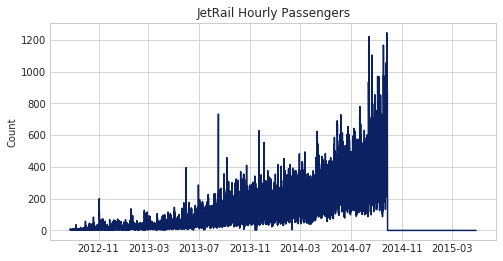

In [51]:
ydates = tDf['Datetime']
ycounts = tDf['Count']
plt.figure(figsize=(8,4))
plt.plot_date(x=ydates, y=ycounts, fmt='#0B2161')
plt.title('JetRail Hourly Passengers')
plt.ylabel('Count')
plt.xticks()
plt.yticks()
plt.grid(True)
plt.show();

### Daily

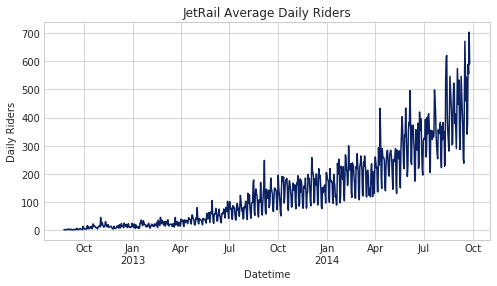

In [24]:
daily = trainTs.resample('D').mean()
daily.plot(title='JetRail Average Daily Riders', figsize=(8,4), color='#0B2161')
plt.ylabel('Daily Riders');

### Weekly

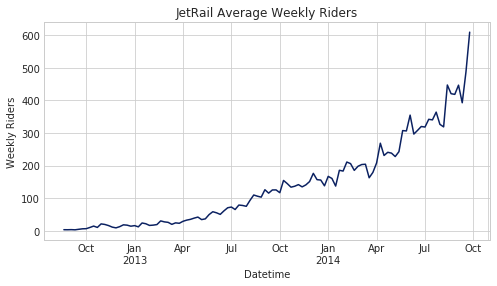

In [25]:
weekly = trainTs.resample('W').mean()
weekly.plot(title='JetRail Average Weekly Riders', figsize=(8,4),  color='#0B2161')
plt.ylabel('Weekly Riders');

### Monthly

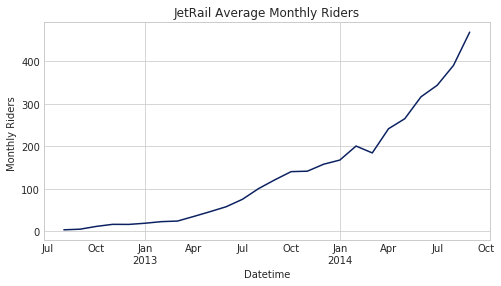

In [26]:
mthly = trainTs.resample('M').mean()
mthly.plot( title='JetRail Average Monthly Riders',  figsize=(8,4), color='#0B2161')
plt.ylabel('Monthly Riders ');

### Hourly / Hour

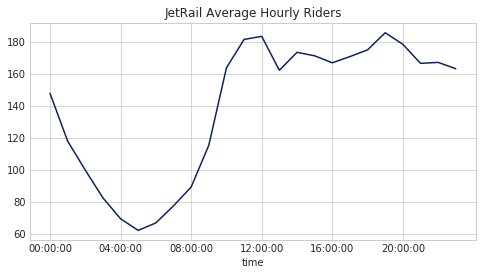

In [28]:
by_time = trainTs.groupby(trainTs.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, title='JetRail Average Hourly Riders', figsize=(8,4), color='#0B2161')
plt.show();

### First 24 / Last 24

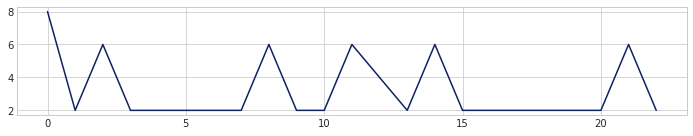

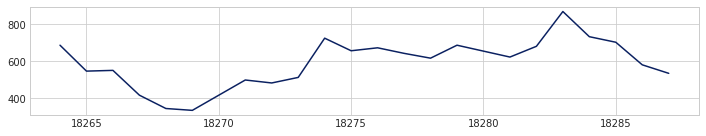

In [50]:
trainDfTs = trainDf
trainDfTs.reset_index(inplace=True)
plt.figure(figsize=(12, 2))
plt.plot(trainDfTs[0:23].Count, color='#0B2161')
plt.show();
plt.figure(figsize=(12, 2))
plt.plot(trainDfTs[-24:].Count, color='#0B2161')
plt.show();

### Test #1: Stationary but w/ Daily Seasonality 

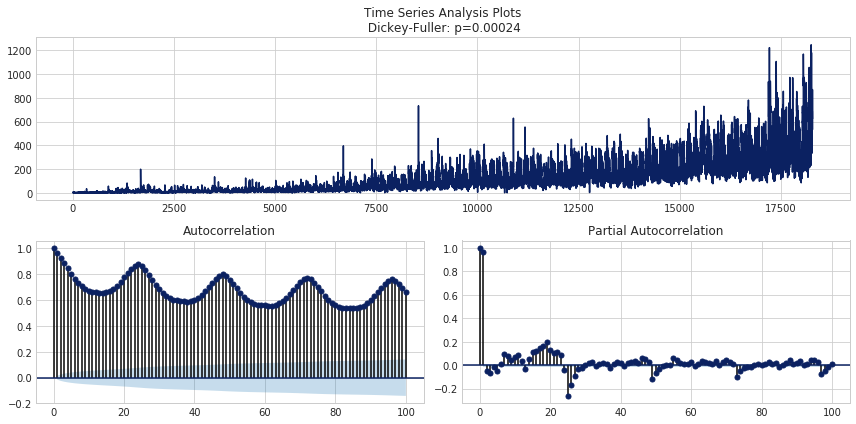

In [41]:
tsplot(trainDfTs.Count, lags=100)

### Test #2: More stationary but w/ significant auto-correlation

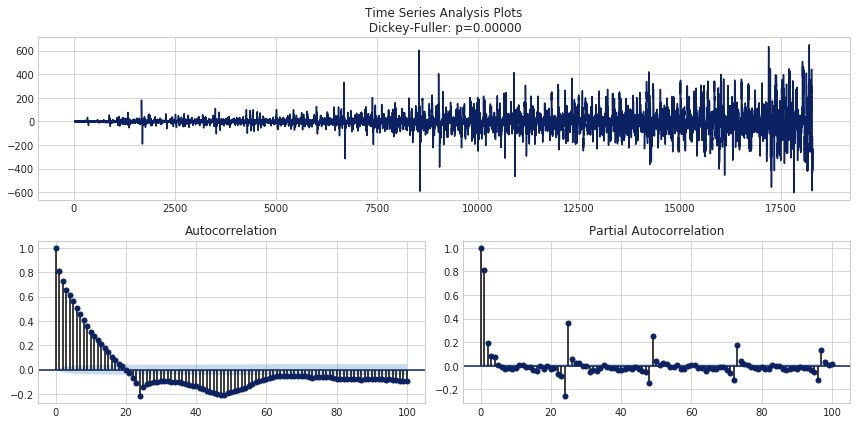

In [42]:
trainDfTs_diff = trainDfTs.Count - trainDfTs.Count.shift(24)
tsplot(trainDfTs_diff[24:], lags=100)

#### White Noise example (complete Stationarity)

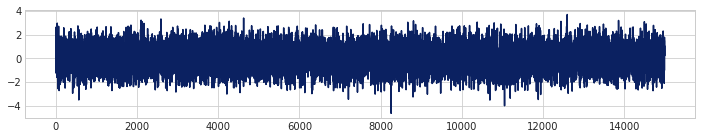

In [43]:
white_noise = np.random.normal(size=15000)
plt.figure(figsize=(12, 2))
plt.plot(white_noise, color='#0B2161')
plt.show();

### Test #3: Stationized w/ no significant lag correlation

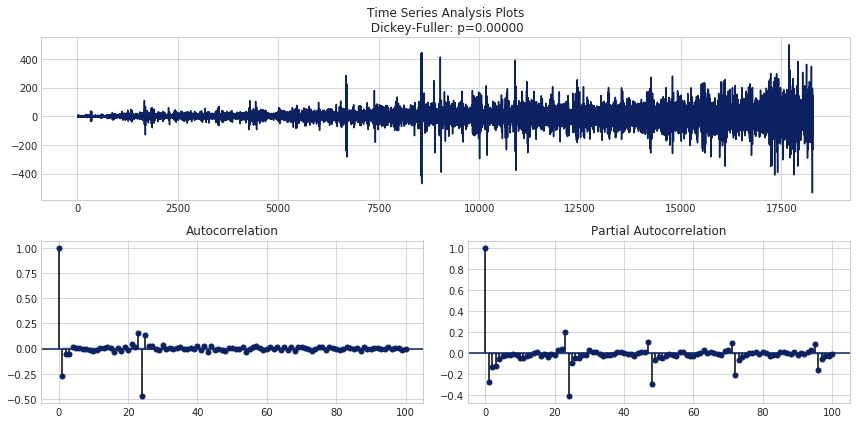

In [44]:
trainDfTs_diff = trainDfTs_diff - trainDfTs_diff.shift(1)
tsplot(trainDfTs_diff[24+1:], lags=100)

### ARIMA Model w/ Seasonal Difference

In [55]:
ts_model = sm.tsa.statespace.SARIMAX(trainDfTs.Count, order=(3, 1, 3), seasonal_order=(5, 1, 2, 24)).fit(disp=-1)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [57]:
print(ts_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Count   No. Observations:                18288
Model:             SARIMAX(3, 1, 3)x(5, 1, 2, 24)   Log Likelihood              -89110.817
Date:                            Sat, 08 Dec 2018   AIC                         178249.633
Time:                                    16:46:23   BIC                         178359.010
Sample:                                         0   HQIC                        178285.576
                                          - 18288                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2101      0.028      7.435      0.000       0.155       0.265
ar.L2          0.9474      0.025   

### Model Diagnostics

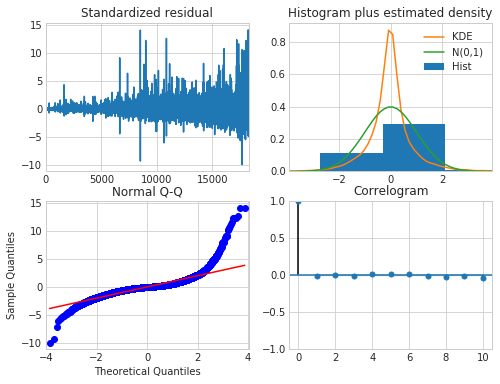

In [73]:
ts_model.plot_diagnostics(figsize=(8, 6))
plt.show();

### Forecast Test Data (5112 steps)

In [60]:
n_steps = 5111
forecast = ts_model.predict(start = trainTs.shape[0], end = trainTs.shape[0]+n_steps)

### Test Forecast

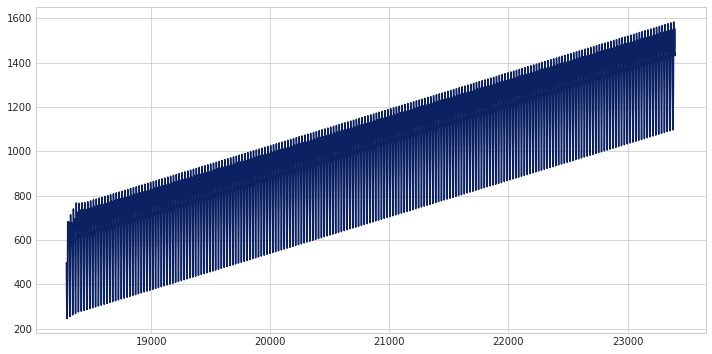

In [64]:
forecast.plot(figsize=(12, 6), color='#0B2161')
plt.show();

### Create forecast for Hackathon Contest

In [69]:
test_forecast = []
test_forecast = [round(t) for t in forecast]
forecast_series = pd.Series(test_forecast)

In [74]:
forecast_series.head()
forecast_series.tail()

0    498
1    396
2    354
3    291
4    257
dtype: int64

5107    1554
5108    1490
5109    1450
5110    1432
5111    1444
dtype: int64

### Build .csv for Contest Submission

In [ ]:
csvfile = '/home/ubuntu/jetrail_forecast.csv'

cnt = 18287
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in test_forecast:
        cnt = cnt + 1
        writer.writerow([cnt,val])

In [79]:
testDf['Forecast'] = forecast_series.values
testDf.head()
testDf.tail()

,Count,Forecast
Datetime,,
2014-09-26 00:00:00,0,498
2014-09-26 01:00:00,0,396
2014-09-26 02:00:00,0,354
2014-09-26 03:00:00,0,291
2014-09-26 04:00:00,0,257


,Count,Forecast
Datetime,,
2015-04-26 19:00:00,0,1554
2015-04-26 20:00:00,0,1490
2015-04-26 21:00:00,0,1450
2015-04-26 22:00:00,0,1432
2015-04-26 23:00:00,0,1444


In [78]:
test_riders = testDf['Forecast'].sum()
print(test_riders)

4843086


In [80]:
testDf['Count'] = testDf['Forecast']

In [81]:
testDf.drop(['Forecast'], axis=1, inplace=True)

In [88]:
testDf.reset_index(inplace=True)

In [89]:
trainDf.head()
testDf.head()

,Datetime,Count
0,2012-08-25 00:00:00,8
1,2012-08-25 01:00:00,2
2,2012-08-25 02:00:00,6
3,2012-08-25 03:00:00,2
4,2012-08-25 04:00:00,2


,Datetime,Count
0,2014-09-26 00:00:00,498
1,2014-09-26 01:00:00,396
2,2014-09-26 02:00:00,354
3,2014-09-26 03:00:00,291
4,2014-09-26 04:00:00,257


### Train with Test Prediction

\begin{align*}
  \text{Root mean squared error: RMSE} & = \sqrt{\text{mean}(e_{t}^2)}.
\end{align*}

In [90]:
tDf = pd.concat([trainDf, testDf])
tDf.reset_index(inplace=True)
tDf.head()
tDf.tail()
tTs = tDf.Count
tTs.head()
tTs.tail()

,index,Datetime,Count
0,0,2012-08-25 00:00:00,8
1,1,2012-08-25 01:00:00,2
2,2,2012-08-25 02:00:00,6
3,3,2012-08-25 03:00:00,2
4,4,2012-08-25 04:00:00,2


,index,Datetime,Count
23395,5107,2015-04-26 19:00:00,1554
23396,5108,2015-04-26 20:00:00,1490
23397,5109,2015-04-26 21:00:00,1450
23398,5110,2015-04-26 22:00:00,1432
23399,5111,2015-04-26 23:00:00,1444


0    8
1    2
2    6
3    2
4    2
Name: Count, dtype: int64

23395    1554
23396    1490
23397    1450
23398    1432
23399    1444
Name: Count, dtype: int64

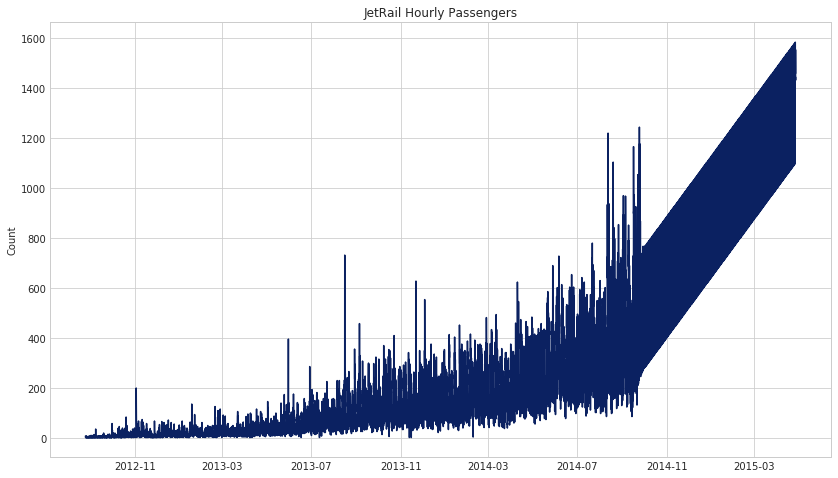

In [93]:
ydates = tDf['Datetime']
ycounts = tDf['Count']
plt.figure(figsize=(14,8))
plt.plot_date(x=ydates, y=ycounts, fmt='#0B2161')
plt.title('JetRail Hourly Passengers')
plt.ylabel('Count')
plt.xticks()
plt.yticks()
plt.grid(True)
plt.show();

### End of Capstone